<img src="header_anwender.png" align="left"/>

# Anwendungsbeispiel Import of audio data with classification

Das Ziel dieses Beispieles ist es die Arbeit mit Audiodaten, den Import, die Vorbereitung und die Klassifikation zu erklären. Dabei werden folgende Schritte durchgeführt:

- Dynamisches Laden und entpacken der Audiodaten von einer externen Quelle
- Review der Organisation auf dem Filesystem
- Laden der Daten
- Transformationen
- Training
- Analyse

Der verwendete Datensatz heisst ESC-50 [1] mit 50 Klassen von Geräuschen in Dateien organisiert. Die Audiodaten sind jeweils 5 Sekunden lang und haben 40 Samples pro Klasse.


Der Code für das Beispiel ist aus [2],[3],[4] und [5] kombiniert.


Quellen für die Beispiele und Daten:

- [1] [https://github.com/karolpiczak/ESC-50/blob/master/LICENSE](https://github.com/karolpiczak/ESC-50/blob/master/LICENSE) (Hinweise auf Unterlizenzen der Daten)
- [2] [https://github.com/CarmineCella/esc50_keras/blob/master/esc50_keras.py](https://github.com/CarmineCella/esc50_keras/blob/master/esc50_keras.py)
- [3] [https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7](https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7)
- [4] [https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram](https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram)
- [5] [https://ipython-books.github.io/117-creating-a-sound-synthesizer-in-the-notebook/](https://ipython-books.github.io/117-creating-a-sound-synthesizer-in-the-notebook/)

Zitat der Datenquelle:
```
K. J. Piczak. ESC: Dataset for Environmental Sound Classification. Proceedings of the 23rd Annual ACM Conference on Multimedia, Brisbane, Australia, 2015.
```





In [1]:
import os
import os.path
import logging
import fnmatch
import joblib
import zipfile
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)


#
# Tensorflow und Keras
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#
# Für GPU Support
#
tflogger = tf.get_logger()
tflogger.setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Ausgabe der Versionen
#
print('working on keras version {} on tensorflow {} using sklearn {}'.format ( tf.keras.__version__, tf.version.VERSION, sklearn.__version__ ) )

[]
working on keras version 2.11.0 on tensorflow 2.11.0 using sklearn 1.2.2


# Hilfsfunktionen

In [2]:
urlDataSource = 'https://github.com/karoldvl/ESC-50/archive/master.zip'
localExtractionFolder = 'data/ESC-50'
localDataArchive = 'data/ESC-50/master.zip'
audioData = localExtractionFolder + '/ESC-50-master/audio'

sampleRate = 22050
sampleLen = 110250 # in samples is 5 sec @ 22050

In [3]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,extraction_path,dataset_file_path):
    if (not os.path.exists(extraction_path)):
        os.makedirs(extraction_path)
    if os.path.exists(localDataArchive):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {}".format(url))

def extract_dataset(dataset_file_path, extraction_directory):    
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden der Daten

In [4]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localExtractionFolder,localDataArchive)

archive already downloaded.


In [5]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/ESC-50/master.zip to data/ESC-50 done.


# Organisation von Audiodaten auf dem Filesystem

Die Audiodateien liegen alle in einem Verzeichnis. Die Zuordnung der Klasse ist im Dateinamen kodiert und in einer Datenbank gespeichert.
Details dazu unter [[1]](https://github.com/karolpiczak/ESC-50)

<img src="info.png" align="left"/> 

In [6]:
#
# Auslesen der Datenbank
#
df = pd.read_csv( localExtractionFolder + '/ESC-50-master/meta/esc50.csv')

In [7]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [8]:
df.tail()

,filename,fold,target,category,esc10,src_file,take
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A
1999,5-9032-A-0.wav,5,0,dog,True,9032,A


In [9]:
#
# Sammeln der Klasseninformation
#
classes = df[['target', 'category']].values.tolist()
classes = set(['{} {}'.format(c[0], c[1]) for c in classes])
classes = np.array([c.split(' ') for c in classes])
classes = {k: v for k, v in classes}
print(classes)

{'7': 'insects', '10': 'rain', '41': 'chainsaw', '45': 'train', '17': 'pouring_water', '3': 'cow', '28': 'snoring', '4': 'frog', '22': 'clapping', '13': 'crickets', '37': 'clock_alarm', '24': 'coughing', '31': 'mouse_click', '20': 'crying_baby', '36': 'vacuum_cleaner', '11': 'sea_waves', '48': 'fireworks', '27': 'brushing_teeth', '33': 'door_wood_creaks', '2': 'pig', '14': 'chirping_birds', '46': 'church_bells', '29': 'drinking_sipping', '23': 'breathing', '9': 'crow', '8': 'sheep', '30': 'door_wood_knock', '18': 'toilet_flush', '15': 'water_drops', '47': 'airplane', '25': 'footsteps', '12': 'crackling_fire', '19': 'thunderstorm', '35': 'washing_machine', '34': 'can_opening', '44': 'engine', '1': 'rooster', '0': 'dog', '49': 'hand_saw', '32': 'keyboard_typing', '40': 'helicopter', '39': 'glass_breaking', '43': 'car_horn', '26': 'laughing', '42': 'siren', '6': 'hen', '5': 'cat', '16': 'wind', '38': 'clock_tick', '21': 'sneezing'}


# Analyse der Daten

In [10]:
#
# Einlesen von 5 files
#
x_check = []
count = 0
for root, dir, files in os.walk(audioData):
    waves = fnmatch.filter(files, "*.wav")
    for item in waves:
        soundFile = os.path.join(root, item)
        yt, sr = librosa.core.load (soundFile, mono=True)

        print('found file {} with data shape {} and sampling rate {}'.format(soundFile,yt.shape,sr))
        
        x_check.append(yt)
        count = count + 1
        if count > 5:
            break

x_check = np.array(x_check)            

found file data/ESC-50/ESC-50-master/audio/1-104089-A-22.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/3-246513-B-16.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/1-96950-B-9.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/2-105270-A-47.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/4-90014-B-42.wav with data shape (110250,) and sampling rate 22050
found file data/ESC-50/ESC-50-master/audio/1-47273-A-21.wav with data shape (110250,) and sampling rate 22050


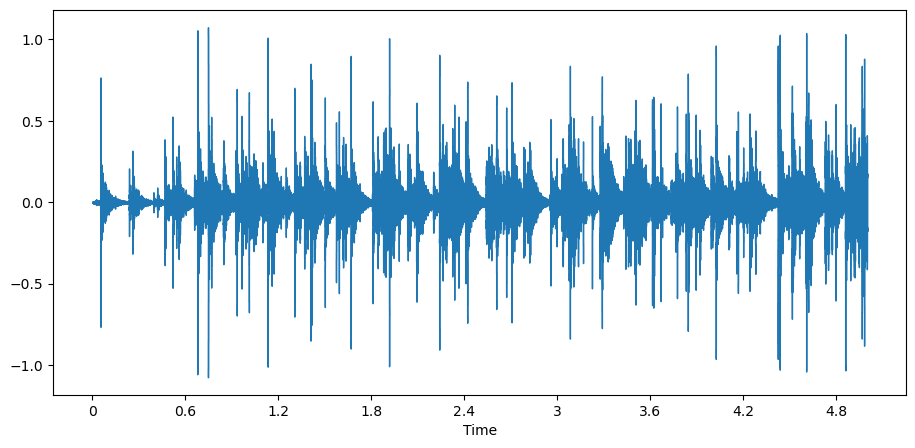

In [54]:
#
# Anzeige als PCM Kurven
#
displayIndex = 0
x_show = x_check[displayIndex]

plt.figure(figsize=(11, 5))
librosa.display.waveshow(x_show, sr=sampleRate)

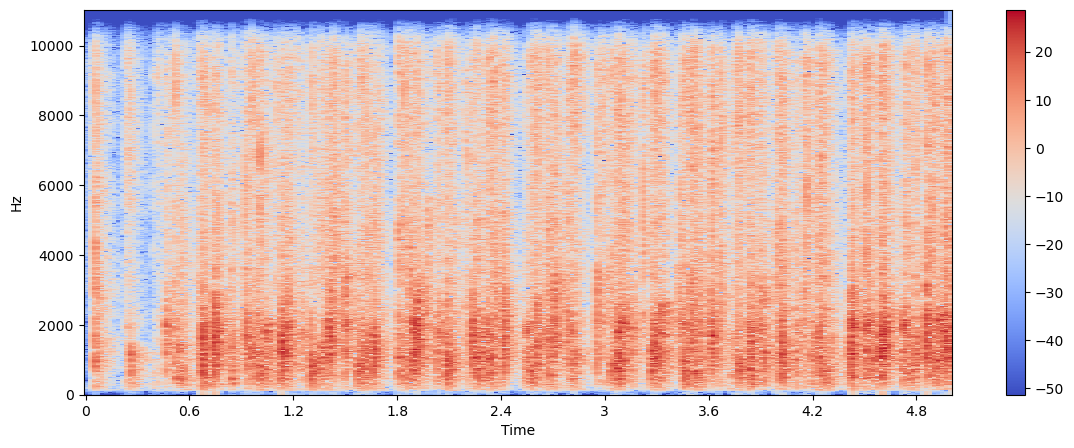

In [55]:
X = librosa.stft(x_show)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

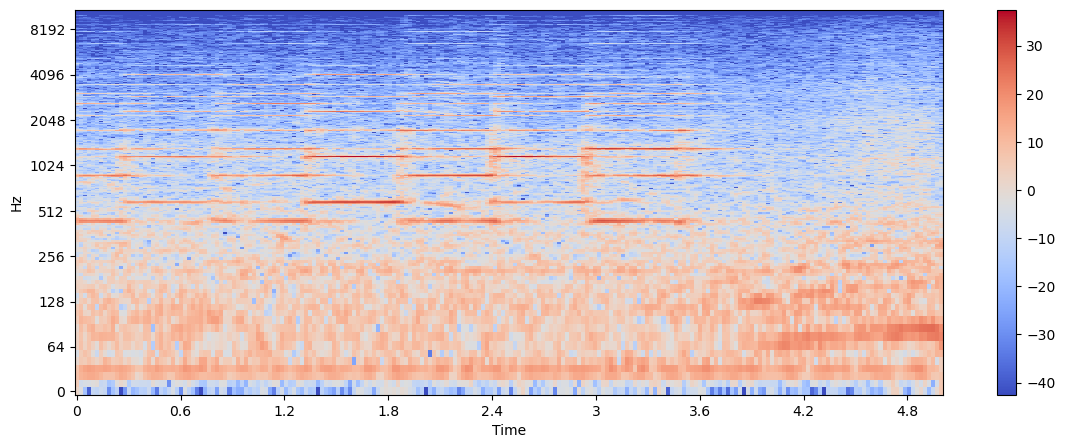

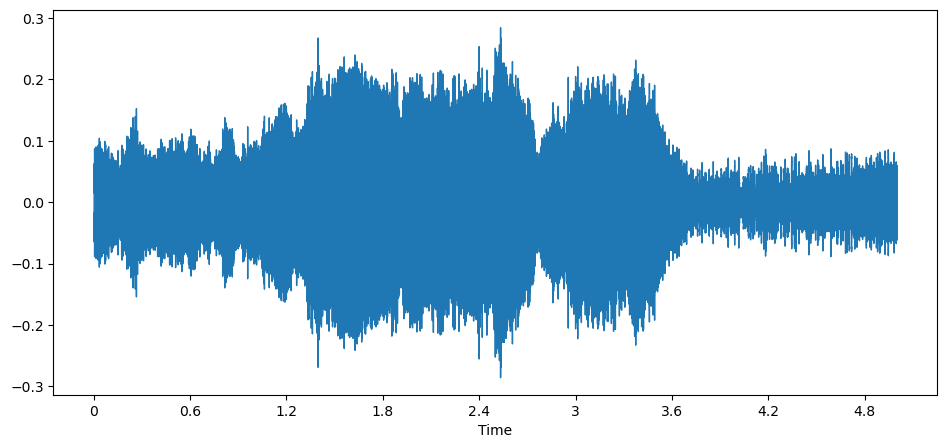

In [49]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.figure(figsize=(11.4, 5))
librosa.display.waveshow(x_show, sr=sampleRate)

In [50]:
from IPython.display import (
    Audio, display, clear_output)

In [56]:
display(Audio(x_show, rate=sampleRate, autoplay=True))

# Erzeugen der Trainingsdaten

https://en.wikipedia.org/wiki/Constant-Q_transform

<img src="info.png" align="left"/> 

In [19]:
#
# Berechnen der Featuretransformation für Audio
# cqt 
# 

# step size
window = 1024
# frequency pins
bins = 32 #64

def get_features (file, hop, bins):
    
    y = np.zeros(sampleLen);   
    yt, sr = librosa.core.load (file, mono=True)
    
    if len(yt) == 0: 
        print ('found empty file ' + file )
        return 0

    min_length = min(len(y), len(yt))
    y[:min_length] = yt[:min_length]
    
    # https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html
    #C = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop, n_mfcc = bins)  

    #https://librosa.github.io/librosa/generated/librosa.core.cqt.html
    C = np.log1p( 1000 * np.abs (librosa.core.cqt( y=y, sr=sr, hop_length=hop, n_bins=bins)))
    
    return C

#memory = joblib.Memory(cachedir=localExtractionFolder+'/esc50_joblib', verbose=0)
memory = joblib.Memory(verbose=0)

cached_get_features = memory.cache(get_features)


def compute_features (root_path):
        
    classes = 50
    samples = 0

    y_data = []    
    X_data = []
    
    for root, dir, files in os.walk(root_path):
        
        waves = fnmatch.filter(files, "*.wav")

        if len(waves) != 0:
            for item in waves:
                # e.g. 2-39443-A-19.wav
                fileName = os.path.splitext ( os.path.basename(item) )[0] 
                classID = int(fileName.split('-')[3])
                
                mfcc = cached_get_features( os.path.join(root, item), window, bins)
                print(".",end='')

                X_data.append(mfcc)
                y_data.append(classID)
                
                samples = samples + 1
                if samples >= 1000:
                    break

    X_data = np.stack(X_data, axis=2)
    
    print()
    print('shape features {}'.format(X_data.shape))
    
    X_data = np.transpose(X_data, (2,0,1))
    d1 = X_data.shape[0]
    d2 = X_data.shape[1]
    d3 = X_data.shape[2]    
    X_data = np.reshape(X_data, (d1,d2,d3,1))
    y_data = np.array(y_data)    

    print('shape transformed {}'.format(X_data.shape))
    print ("samples = " + str (samples) )

    return X_data, y_data, classes, samples

In [20]:
x_data, y_data, classes, samples = compute_features (audioData)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [22]:
x_data = x_data.astype('float32')
y_data = y_data.astype('uint8')

# Anzeige der Features als Bild

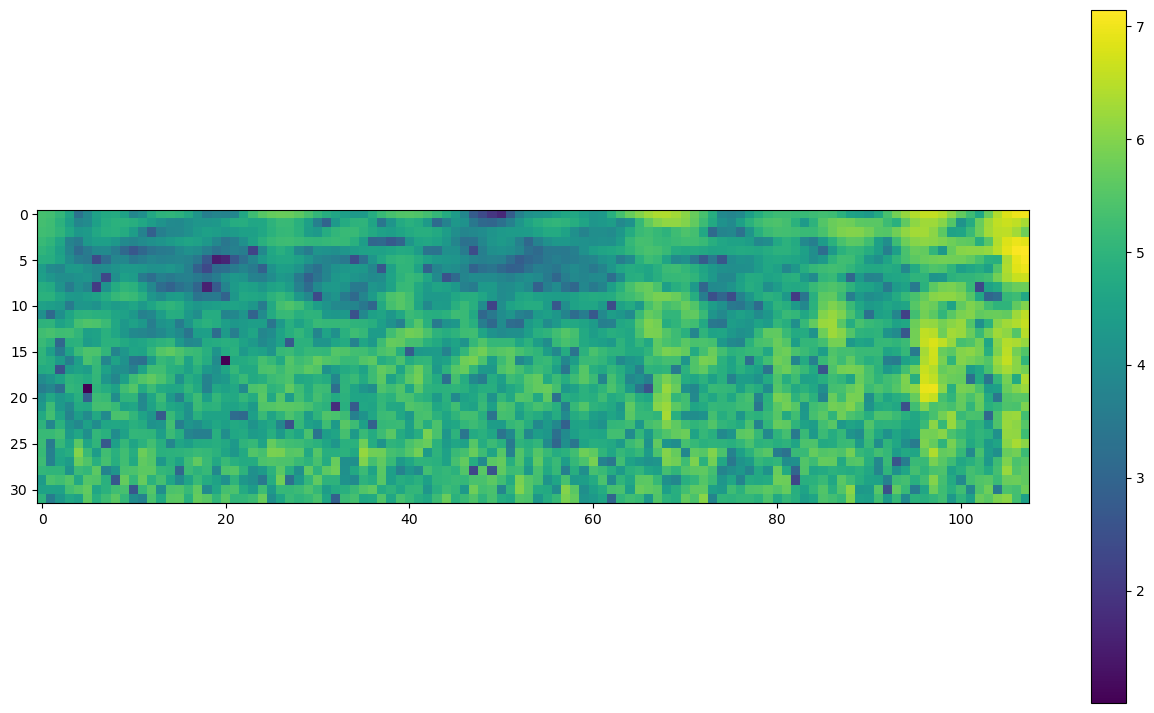

In [23]:
x_show = x_data[displayIndex]
x_show = np.reshape(x_show, (32,108))
#x_show = np.transpose(x_show,(1,0))
plt.imshow(x_show)
plt.colorbar()

# Anzeige der Klassenverteilung

In [24]:
y_data[0:5]

array([22, 16,  9, 47, 42], dtype=uint8)

<Axes: >

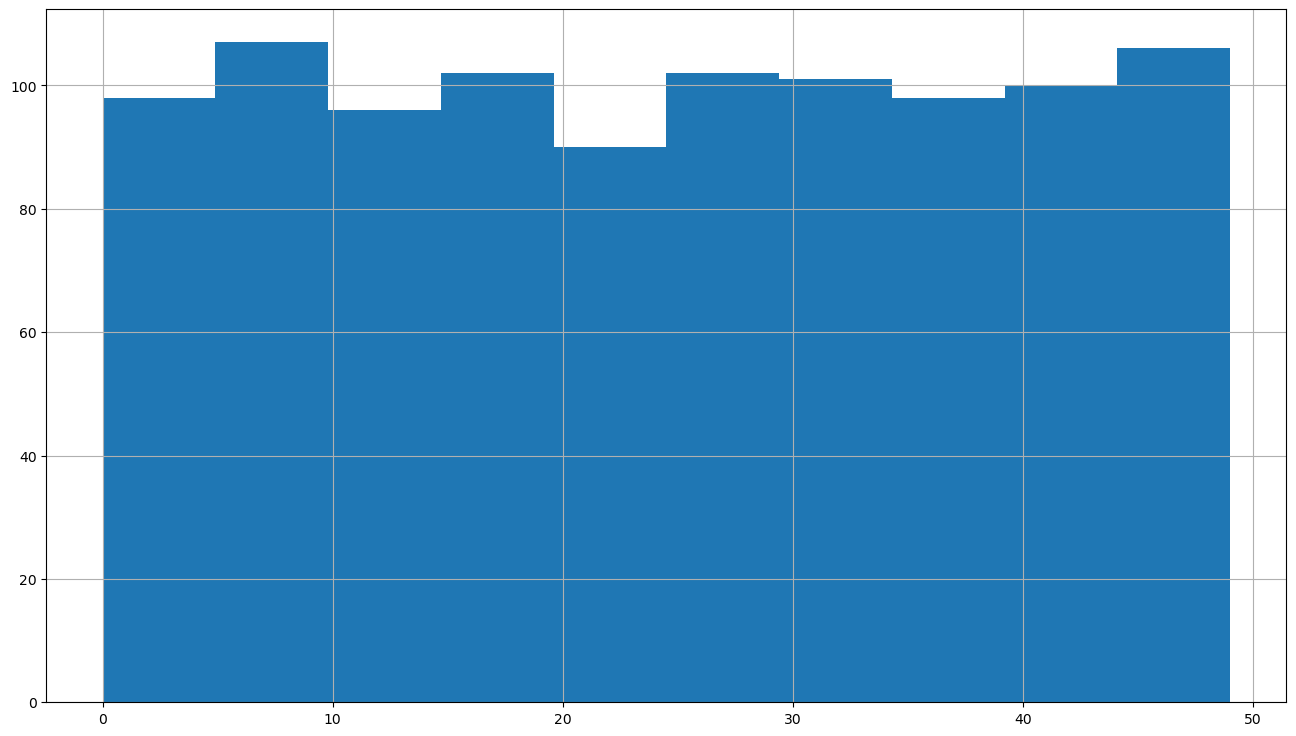

In [25]:
pd.DataFrame(y_data)[0].hist()

# Normalisieren der Daten

In [26]:
def standardize (x):
    mu = np.mean (x, axis=0)
    de = np.std (x, axis=0)
    
    eps = np.finfo('float32').eps
    x = (x - mu) / (eps + (de*2.0) )
    return x

In [27]:
x_data_std = standardize(x_data)

In [28]:
# 
# Klassen in one-hot encoding umrechnen
#
y_data_onehot = to_categorical(y_data, classes )

In [29]:
y_data_onehot.shape

(1000, 50)

In [30]:
y_data_onehot[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

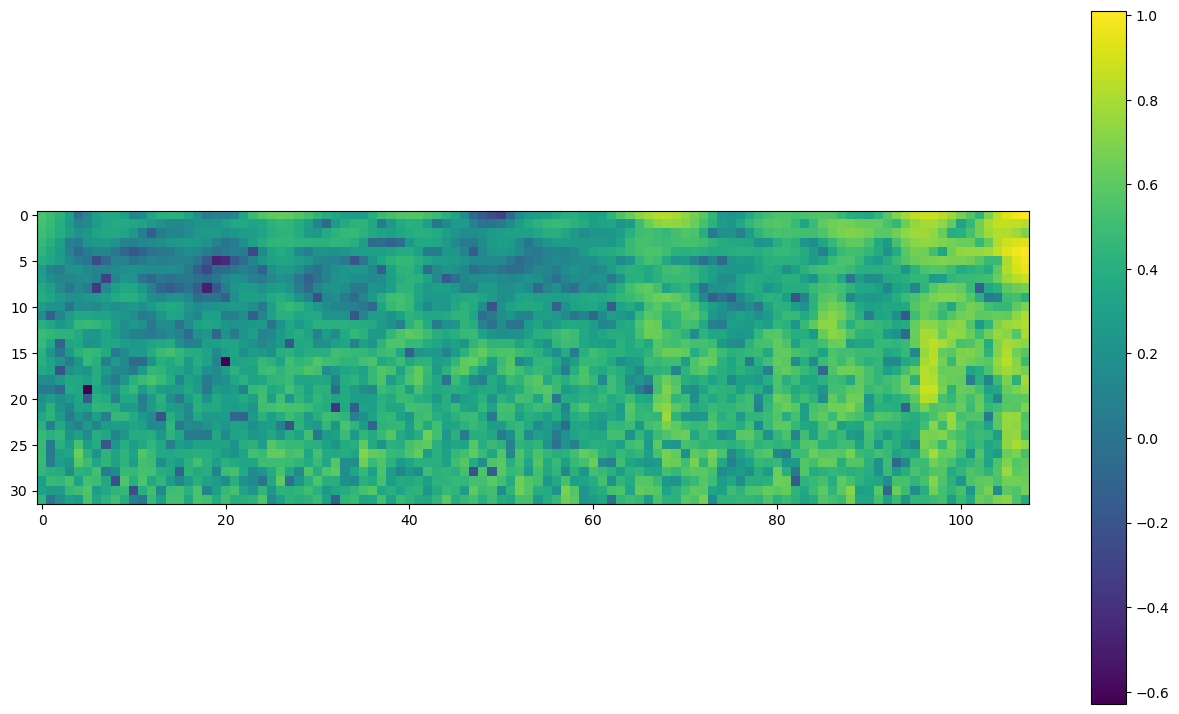

In [31]:
#
# Nochmals checken
#
x_show = x_data_std[displayIndex]
x_show = np.reshape(x_show, (32,108))
#x_show = np.transpose(x_show,(1,0))
plt.imshow(x_show)
plt.colorbar()

# Train und Test Split

In [32]:
#
# Split der Daten in Train und Test(validation) Datensätze
#
x_train, x_validation, y_train, y_validation = train_test_split(x_data_std, y_data_onehot, test_size=0.20, random_state=42)

print('shapes {} {} {} {}'.format(x_train.shape, x_validation.shape, y_train.shape, y_validation.shape ))

shapes (800, 32, 108, 1) (200, 32, 108, 1) (800, 50) (200, 50)


# Model bauen

In [33]:
#
# Erzeugen eines einfache Modelles
#
def createModel():
    
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=3, strides=1, input_shape=(img_rows, img_cols, 1)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, kernel_size=3, strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
     
    model.add(Convolution2D(64, kernel_size=3, strides=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, kernel_size=3, strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    return model


In [34]:
#
# Anlegen des Modelles mit Beschreibung
#
model_cnn = createModel()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 106, 32)       320       
                                                                 
 activation (Activation)     (None, 30, 106, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 104, 32)       9248      
                                                                 
 activation_1 (Activation)   (None, 28, 104, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 52, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 52, 32)        0         
                                                        

In [35]:
#
# Festlegen des Optimizers
#
optimizer = Adam ()
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [36]:
#
# Anlegen des Datengenerators mit Augmentierung
#
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=2,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

In [37]:
#
# Training des Generators
#
it_train = datagen.flow(x_train, y_train, batch_size=32)

In [38]:
callbacks = [History()]

In [39]:
#
# Training des Modelles
#
steps = int(x_train.shape[0] / 32)
history = model_cnn.fit_generator(it_train,
                            steps_per_epoch=steps,
                            epochs=300, 
                            callbacks=callbacks,
                            validation_data=(x_validation, y_validation))

Epoch 1/300


2023-03-24 09:57:58.966959: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 2s 74ms/step - loss: 3.8967 - accuracy: 0.0325 - val_loss: 3.7925 - val_accuracy: 0.0350
Epoch 2/300
25/25 [==============================] - 2s 71ms/step - loss: 3.7463 - accuracy: 0.0487 - val_loss: 3.7430 - val_accuracy: 0.0400
Epoch 3/300
25/25 [==============================] - 2s 76ms/step - loss: 3.6774 - accuracy: 0.0437 - val_loss: 3.6969 - val_accuracy: 0.0350
Epoch 4/300
25/25 [==============================] - 2s 75ms/step - loss: 3.6578 - accuracy: 0.0525 - val_loss: 3.6666 - val_accuracy: 0.0400
Epoch 5/300
25/25 [==============================] - 2s 78ms/step - loss: 3.6439 - accuracy: 0.0700 - val_loss: 3.6574 - val_accuracy: 0.0400
Epoch 6/300
25/25 [==============================] - 2s 74ms/step - loss: 3.5957 - accuracy: 0.0650 - val_loss: 3.6512 - val_accuracy: 0.0550
Epoch 7/300
25/25 [==============================] - 2s 80ms/step - loss: 3.6020 - accuracy: 0.0575 - val_loss: 3.6735 - val_accuracy: 0.0350
Epoch 8/300
25/25 

25/25 [==============================] - 4s 147ms/step - loss: 2.9401 - accuracy: 0.1875 - val_loss: 3.1267 - val_accuracy: 0.2100
Epoch 59/300
25/25 [==============================] - 4s 143ms/step - loss: 2.9065 - accuracy: 0.1762 - val_loss: 3.1088 - val_accuracy: 0.1850
Epoch 60/300
25/25 [==============================] - 4s 144ms/step - loss: 2.9669 - accuracy: 0.1550 - val_loss: 3.1527 - val_accuracy: 0.1800
Epoch 61/300
25/25 [==============================] - 4s 147ms/step - loss: 2.9152 - accuracy: 0.1963 - val_loss: 3.1900 - val_accuracy: 0.2050
Epoch 62/300
25/25 [==============================] - 4s 156ms/step - loss: 2.8984 - accuracy: 0.1737 - val_loss: 3.1805 - val_accuracy: 0.1500
Epoch 63/300
25/25 [==============================] - 4s 171ms/step - loss: 2.9459 - accuracy: 0.1838 - val_loss: 3.0698 - val_accuracy: 0.1850
Epoch 64/300
25/25 [==============================] - 4s 161ms/step - loss: 2.8499 - accuracy: 0.2175 - val_loss: 3.1202 - val_accuracy: 0.1650
Epoch

Epoch 115/300
25/25 [==============================] - 4s 163ms/step - loss: 2.5794 - accuracy: 0.2575 - val_loss: 3.3003 - val_accuracy: 0.2400
Epoch 116/300
25/25 [==============================] - 4s 164ms/step - loss: 2.6068 - accuracy: 0.2525 - val_loss: 3.2923 - val_accuracy: 0.2150
Epoch 117/300
25/25 [==============================] - 4s 164ms/step - loss: 2.5854 - accuracy: 0.2400 - val_loss: 3.3468 - val_accuracy: 0.2550
Epoch 118/300
25/25 [==============================] - 4s 166ms/step - loss: 2.5821 - accuracy: 0.2500 - val_loss: 3.2376 - val_accuracy: 0.1950
Epoch 119/300
25/25 [==============================] - 4s 161ms/step - loss: 2.6134 - accuracy: 0.2587 - val_loss: 3.1967 - val_accuracy: 0.2000
Epoch 120/300
25/25 [==============================] - 4s 169ms/step - loss: 2.5549 - accuracy: 0.2612 - val_loss: 3.2772 - val_accuracy: 0.2450
Epoch 121/300
25/25 [==============================] - 4s 161ms/step - loss: 2.5045 - accuracy: 0.2550 - val_loss: 3.4293 - val_ac

25/25 [==============================] - 4s 172ms/step - loss: 2.3664 - accuracy: 0.3100 - val_loss: 3.3348 - val_accuracy: 0.2300
Epoch 172/300
25/25 [==============================] - 4s 171ms/step - loss: 2.3467 - accuracy: 0.3063 - val_loss: 3.3236 - val_accuracy: 0.2550
Epoch 173/300
25/25 [==============================] - 4s 168ms/step - loss: 2.4088 - accuracy: 0.2962 - val_loss: 3.3079 - val_accuracy: 0.2500
Epoch 174/300
25/25 [==============================] - 5s 182ms/step - loss: 2.3563 - accuracy: 0.3050 - val_loss: 3.2742 - val_accuracy: 0.2700
Epoch 175/300
25/25 [==============================] - 4s 169ms/step - loss: 2.3580 - accuracy: 0.3262 - val_loss: 3.3767 - val_accuracy: 0.2250
Epoch 176/300
25/25 [==============================] - 4s 172ms/step - loss: 2.3626 - accuracy: 0.2837 - val_loss: 3.4189 - val_accuracy: 0.2500
Epoch 177/300
25/25 [==============================] - 4s 173ms/step - loss: 2.3293 - accuracy: 0.3262 - val_loss: 3.3145 - val_accuracy: 0.2550

25/25 [==============================] - 5s 202ms/step - loss: 2.2043 - accuracy: 0.3487 - val_loss: 3.4985 - val_accuracy: 0.2900
Epoch 228/300
25/25 [==============================] - 5s 199ms/step - loss: 2.2347 - accuracy: 0.3300 - val_loss: 3.4994 - val_accuracy: 0.2850
Epoch 229/300
25/25 [==============================] - 5s 195ms/step - loss: 2.1473 - accuracy: 0.3675 - val_loss: 3.4558 - val_accuracy: 0.2700
Epoch 230/300
25/25 [==============================] - 5s 191ms/step - loss: 2.2372 - accuracy: 0.3688 - val_loss: 3.3967 - val_accuracy: 0.2700
Epoch 231/300
25/25 [==============================] - 4s 161ms/step - loss: 2.1232 - accuracy: 0.3663 - val_loss: 3.6020 - val_accuracy: 0.2800
Epoch 232/300
25/25 [==============================] - 4s 167ms/step - loss: 2.2275 - accuracy: 0.3587 - val_loss: 3.5143 - val_accuracy: 0.2350
Epoch 233/300
25/25 [==============================] - 4s 170ms/step - loss: 2.2503 - accuracy: 0.3413 - val_loss: 3.4599 - val_accuracy: 0.2800

25/25 [==============================] - 4s 177ms/step - loss: 2.0259 - accuracy: 0.4038 - val_loss: 3.6712 - val_accuracy: 0.2850
Epoch 284/300
25/25 [==============================] - 4s 161ms/step - loss: 2.0259 - accuracy: 0.3787 - val_loss: 3.6487 - val_accuracy: 0.2700
Epoch 285/300
25/25 [==============================] - 4s 162ms/step - loss: 1.9376 - accuracy: 0.4137 - val_loss: 3.7179 - val_accuracy: 0.2750
Epoch 286/300
25/25 [==============================] - 4s 158ms/step - loss: 2.0057 - accuracy: 0.4187 - val_loss: 3.7370 - val_accuracy: 0.2500
Epoch 287/300
25/25 [==============================] - 4s 165ms/step - loss: 2.0425 - accuracy: 0.3825 - val_loss: 3.4915 - val_accuracy: 0.2500
Epoch 288/300
25/25 [==============================] - 4s 176ms/step - loss: 2.0977 - accuracy: 0.3925 - val_loss: 3.4656 - val_accuracy: 0.2950
Epoch 289/300
25/25 [==============================] - 4s 150ms/step - loss: 2.0408 - accuracy: 0.3825 - val_loss: 3.4908 - val_accuracy: 0.3150

In [40]:
#
# Prüfung des Modelles
#
score = model_cnn.evaluate(x_validation, y_validation, verbose=0)
print("validation {} {:.3f}" .format(model_cnn.metrics_names[1], score[1]))

validation accuracy 0.310


In [41]:
#
# Ausgabe des Trainingsverlaufes
#
def summarize_diagnostics(history,modelname):
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='green', label='test')
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='green', label='test')
    plt.subplots_adjust(hspace=0.5)
    plt.savefig( 'results/' + modelname + '_plot.png')
    plt.show()
    plt.close()

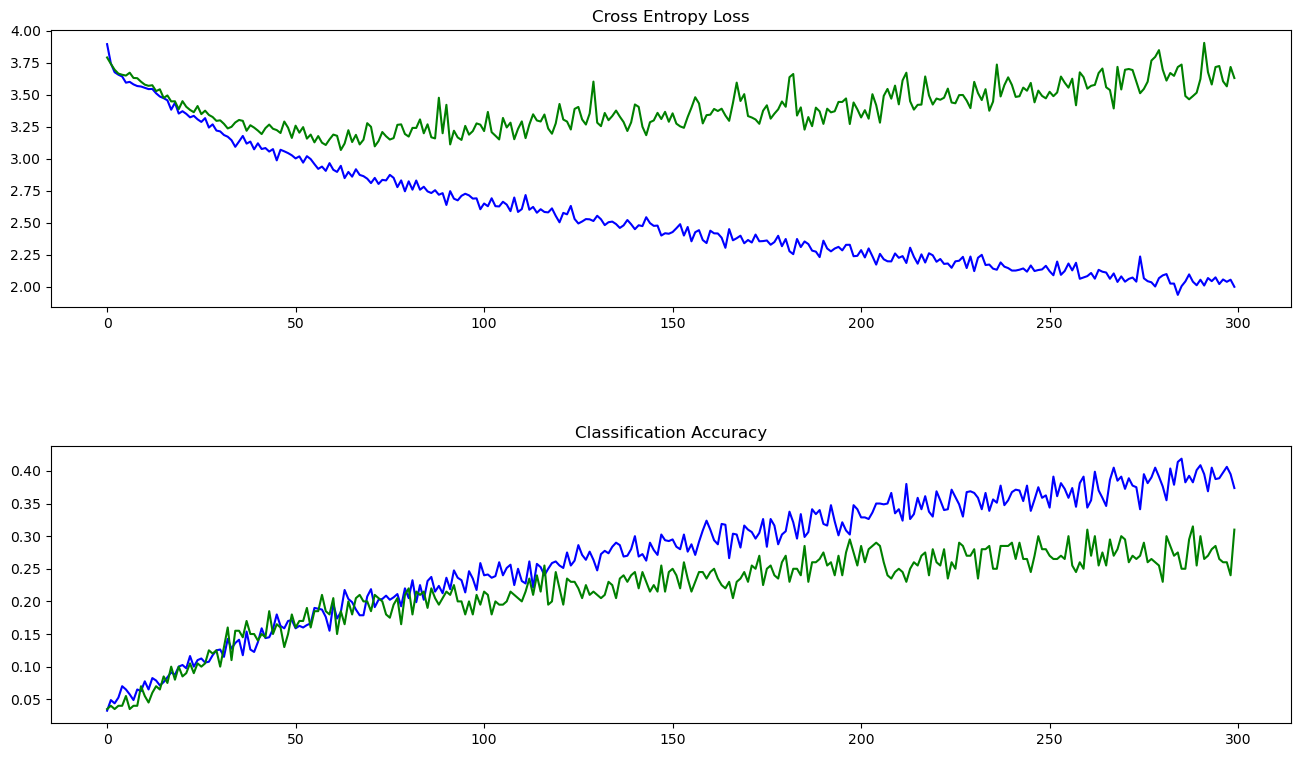

In [42]:
summarize_diagnostics(history,'06_model_cnn')

In [43]:
#
# Speichern des Modelles
#
from keras.models import model_from_json
prefix = 'results/06_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

In [44]:
if True:
    model_json = model_cnn.to_json()
    with open( modelName , "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_cnn.save_weights( weightName )
    print("saved model to disk as {} {}".format(modelName,weightName))

saved model to disk as results/06_model.json results/06_model.h5


In [45]:
#
# Laden eines vortrainierten Modelles
#
if False:
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model_cnn = model_from_json(loaded_model_json)
    # load weights into new model
    model_cnn.load_weights(weightName)
    print("loaded model from disk")

In [46]:
# 
# evaluate loaded model on test data
#
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
score = model_cnn.evaluate(x_validation, y_validation, verbose=0)
print("%s: %.2f%%" % (model_cnn.metrics_names[1], score[1]*100))

accuracy: 31.00%
